This notebook describes the temporal fusion transformers [@lim2021temporal] architecture, and ports it over to keras 3 while making some punctual improvements, including making the notation closer to the paper math.

The original repository is: https://github.com/google-research/google-research/tree/master/tft.

In [135]:
from __future__ import annotations

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from fastcore import docments
from nbdev.showdoc import show_doc


# Introduction

The main characteristics of TFT that make it interesting for nowcasting or forecasting purposes are:

- **multi-horizon forecasting**: the ability to output, at each point in time $t$, a sequence of forecasts for $t+h, h > 1$
- **quantile prediction**: each forecast is accompanied by a quantile band that communicates the amount of uncertainty around a prediction
- **flexible use of different types of inputs**: static inputs (akin to fixed effects), historical input and known future input (eg, important holidays, years that are known to have major sports events such as Olympic games, etc)
- **interpretability**: the model learns to select variables from the space of all input variables to retain only those that are globally meaningful, to assign attention to different parts of the time series, and to identify events of significance


# Notation

* unique entities: $i \in (1, \dots\, I)$
* time periods $t \in [0, T_i]$
  * $k \geq 1$ lags
  * $h \geq 1$ forecasting period
* set of entity-level static covariates: $s_i \in \mathbf{R}^{m_s}$
* set of temporal inputs: $\chi_{i, t} \in \mathbf{R}^{m_\chi}$
  * $\chi_{i,t} = [z_{i,t}, x_{i,t}]$
    * $z_{i,t} \in \mathbf{R}^{m_z}$ are observed inputs
    * $x_{i,t} \in \mathbf{R}^{m_z}$ are a priori known inputs (eg, years that have major sports events)
    * $m_\chi = m_z + m_x$
* target scalars: $y_{i,t}$
  * $\hat{y}_{i,t,q} = f_q(y_{i,t-k:t}, z_{i,t-k:t}, x_{i,t-k:t+h}, s_i)$
* hidden unit size (common across all the TFT architecture): $d_{\text{model}}$
* transformed input of $j$-th variable at time $t$: $\xi_t^{(j)} \in \mathbf{R}^{d_{\text{model}}}$
  * $\Xi_t = [\xi_t^{(1)}, \dots, \xi_t^{(m_\chi)}]$

# Architecture

## Concepts

* **time distributed**: 
  * applies same layer to each of the time steps in the data
    * in other words, a layer with the exact same weights
  * indices:
    * index 0: batch
    * index 1: time
    * indices 2...: data
  * More info: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed

## Components

### Linear layer

> dedicated implementation to better control use of time distribution on vanilla linear layer

$$
\mathbb{Y} = \phi(\mathbf{W} x + \mathbf{b}),
$$ {#eq-dense}

where $x$ is the input to `linear_layer()(x)`, $\mathbb{Y}$ is the output of `linear_layer()(x)`, $\phi$ is an activation function (or no activation function is `activation` is `None`), $\mathbf{W} \in \mathbf{R}^{(d_{\text{size}} \times d_{\text{inputs}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{size}}$ is a vector of biases. Importantly, $\mathbf{W}$ and $\mathbf{b}$ are indexed with $_{\omega}$ to denote weight-sharing when the layer is time-distributed.

In [2]:
def linear_layer(size:int, # Output size
                 activation:str|callable|None=None, # Activation function
                 use_time_distributed:bool=False, # Apply the layer across all time steps?
                 use_bias:bool=True # Include bias in the layer?
)->layers.Dense: # Dense layer
    "Linear layer."

    linear = layers.Dense(size, activation=activation, use_bias=use_bias)
    if use_time_distributed:
        linear = layers.TimeDistributed(linear)
    return linear

In [3]:
#| output: asis
#| echo: false
show_doc(linear_layer, title_level=4)

---

#### linear_layer



Linear layer.

#### Example usage

In [4]:
#| code-fold: show

batch_size = 2
n_timesteps = 5
n_features = 100
layer_size = 8

# input dimensions: batches / timesteps / features
x = np.ones(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# dense layer
linear_td_true = linear_layer(size=layer_size, use_time_distributed=True)
linear_td_false = linear_layer(size=layer_size, use_time_distributed=False)

# output dimensions: batches / timesteps / layer size
assert linear_td_true(x).shape == [batch_size, n_timesteps, layer_size]
assert linear_td_false(x).shape == [batch_size, n_timesteps, layer_size]

Note that the time-distributed linear layer results in the same weights being applied to each time step:

In [5]:
#| code-fold: show

x = np.ones((1, n_timesteps, n_features))
timesteps_equal = []
for i in range(n_timesteps-1):
    timesteps_equal.append((np.array_equal(linear_td_true(x)[0,0,:], linear_td_true(x)[0,i+1,:])))

assert np.all(timesteps_equal)

linear_td_true(x)

<tf.Tensor: shape=(1, 5, 8), dtype=float32, numpy=
array([[[ 0.5619693 ,  1.186127  ,  2.730394  , -0.62543887,
          1.81532   , -1.1254747 ,  1.745105  ,  0.5894729 ],
        [ 0.5619693 ,  1.186127  ,  2.730394  , -0.62543887,
          1.81532   , -1.1254747 ,  1.745105  ,  0.5894729 ],
        [ 0.5619693 ,  1.186127  ,  2.730394  , -0.62543887,
          1.81532   , -1.1254747 ,  1.745105  ,  0.5894729 ],
        [ 0.5619693 ,  1.186127  ,  2.730394  , -0.62543887,
          1.81532   , -1.1254747 ,  1.745105  ,  0.5894729 ],
        [ 0.5619693 ,  1.186127  ,  2.730394  , -0.62543887,
          1.81532   , -1.1254747 ,  1.745105  ,  0.5894729 ]]],
      dtype=float32)>

### Categorical embeddings

> Embeds categorical variables

Most categorical economic variables do not have more than a few dozen different categories, unlike in natural language processing, where vocabulary sizes are counted in the tens of thousands. For this reason, the default number of categories is set at 50. However, this can be adjusted by the user in case there are more unique categories in a variable.

In [6]:
def cat_embed(
    inputs, # Categorical variables with dimensions (batch_size, n_timesteps)
    hidden_layer_size:int, # Hidden layer size,
    n_categories:int=50 # Number of different categories
)->keras.KerasTensor: # $\xi^{(j)}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)
    
    n_timesteps = inputs.shape[1]
    
    embed = keras.Sequential([
        layers.Embedding(
            input_dim=n_categories,
            output_dim=hidden_layer_size,
            #input_length=n_timesteps,
            mask_zero=True
        )
    ])
    return embed(inputs)

In [7]:
#| output: asis
#| echo: false

show_doc(cat_embed, title_level=4)

---

#### cat_embed

>      cat_embed (inputs, hidden_layer_size:int, n_categories:int=50)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| inputs |  |  | Categorical variables with dimensions (batch_size, n_timesteps) |
| hidden_layer_size | int |  | Hidden layer size, |
| n_categories | int | 50 | Number of different categories |
| **Returns** | **keras.KerasTensor** |  | **$\xi\^{(j)}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)** |

#### Example usage

In the code below, the array `x` is created with distinct integers that stand for different categories.

Also, for pedagogical purposes the example code below uses the same number of different categories as potentially exist in the data.

In [8]:
#| code-fold: show

batch_size = 3
n_timesteps = 8
hidden_layer_size = 4
num_diff_categories = 6

x = np.random.randint(low=0, high=num_diff_categories-1, size=(batch_size, n_timesteps))
# inspecting the first batch below; note that same integers have the same embeddings
x[0], cat_embed(x, hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)[0]

(array([4, 0, 0, 1, 0, 0, 0, 4]),
 <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
 array([[-0.04486846, -0.03725325, -0.01615609, -0.02743695],
        [ 0.03812634,  0.04566753,  0.00253998,  0.04429752],
        [ 0.03812634,  0.04566753,  0.00253998,  0.04429752],
        [-0.03978486,  0.03321173, -0.00459155, -0.01740873],
        [ 0.03812634,  0.04566753,  0.00253998,  0.04429752],
        [ 0.03812634,  0.04566753,  0.00253998,  0.04429752],
        [ 0.03812634,  0.04566753,  0.00253998,  0.04429752],
        [-0.04486846, -0.03725325, -0.01615609, -0.02743695]],
       dtype=float32)>)

### Skip connection

> Adds inputs to layer and then implements layer normalisation

$$
\text{LayerNorm}(a + b),
$$ {#eq-skip}

for $a$ and $b$ tensors of the same dimension and $\text{LayerNorm}(\cdot)$ being the layer normalisation (@ba2016layer), ie subtracting $\mu^l$ and dividing by $\sigma^l$ defined as:

$$
\mu^l = \frac{1}{H} \sum_{i=1}^H n_i^l \quad \sigma^l = \sqrt{\frac{1}{H} \sum_{i=1}^H (n_i^l - \mu^l)^2},
$$ {#eq-layernorm}

with $H$ denoting the number of $n$ hidden units in a layer $l$.

* Adding a layer's inputs to its outputs is also called "skip connection"
* The layer is then normalised [@ba2016layer] to avoid having the numbers grow too big, which is detrimental for gradient transmission
  * Layer normalisation uses the same computation both during training and inference times, and is particularly suitable for time series

In [9]:
def add_and_norm(
    x_list # List of input tensors (of the same dimension) for skip connection
    )->keras.KerasTensor: # Normalised tensor with the same dimension as the tensors in the list
    "Adds tensors with same dimensions and then normalises layer"
    tmp = layers.Add()(x_list)
    return layers.LayerNormalization()(tmp)

In [10]:
#| output: asis
#| echo: false
show_doc(add_and_norm, title_level=4)

---

#### add_and_norm

>      add_and_norm (x_list)

Adds tensors with same dimensions and then normalises layer

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x_list |  | List of input tensors (of the same dimension) for skip connection |
| **Returns** | **keras.KerasTensor** | **Normalised tensor with the same dimension as the tensors in the list** |

#### Example usage

In [11]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100

# input dimensions: batches / timesteps / features
x1 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 
x2 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / features
x1x2 = add_and_norm(x_list=[x1, x2])
assert x1.shape == x1x2.shape

Mean values of the normalised layer should be around 0:

In [12]:
print("mean of x1 units at each batch X time step: ", x1.mean(axis=-1), "\n")
print("mean of x2 units at each batch X time step: ", x2.mean(axis=-1), "\n")
print("mean of sum of x1 and x2:"), x1x2.numpy().mean(axis=-1)

mean of x1 units at each batch X time step:  [[ 0.02423079  0.27551868  0.00652721  0.06933863 -0.10110351]
 [ 0.09564999  0.03990795  0.0989942  -0.0499648   0.1612401 ]
 [-0.06676308  0.00422137  0.09121888 -0.09015055 -0.03595006]] 

mean of x2 units at each batch X time step:  [[-0.05670447 -0.09016893 -0.09119486 -0.06959022 -0.08453582]
 [ 0.02237132  0.02594187  0.0632951   0.20154897  0.10926962]
 [ 0.14950795 -0.00929115 -0.03395515  0.06862373  0.00995618]] 

mean of sum of x1 and x2:


(None,
 array([[ 1.7881394e-08,  2.3543835e-08, -2.9802323e-09, -8.3446503e-09,
         -4.3213366e-09],
        [ 5.9604646e-09,  1.7881394e-08,  1.8924474e-08, -1.1324882e-08,
          1.1324882e-08],
        [ 7.1525572e-09,  8.3446503e-09, -4.1723252e-09,  1.5497207e-08,
         -9.2387200e-09]], dtype=float32))

Standard deviation (for the normalised output it should be around 1):

In [13]:
print("std of x1 units at each batch X time step: ", x1.std(axis=-1), "\n")
print("std of x2 units at each batch X time step: ", x2.std(axis=-1), "\n")
print("std of normalised sum of x1 and x2:"), x1x2.numpy().std(axis=-1)

std of x1 units at each batch X time step:  [[1.03262265 0.98802561 1.00921022 1.03635811 1.07990661]
 [0.95147762 0.94877569 0.95247414 1.14646854 0.98394174]
 [0.91501917 0.92605855 1.05916432 0.97791997 1.05818374]] 

std of x2 units at each batch X time step:  [[1.03933124 1.03531164 1.00298616 0.99184543 0.94995457]
 [0.99856704 0.88463574 1.06421894 0.97076696 1.22109697]
 [0.93261229 1.00318975 0.96534888 0.97917265 0.99660251]] 

std of normalised sum of x1 and x2:


(None,
 array([[0.99979943, 0.9997585 , 0.99973226, 0.9997831 , 0.9996915 ],
        [0.99970996, 0.99972373, 0.99973845, 0.9997957 , 0.9997951 ],
        [0.99966604, 0.9997121 , 0.9997507 , 0.9997494 , 0.9997482 ]],
       dtype=float32))

### Gated linear unit (GLU)

> Linear layer that learns how much to gate vs let pass through

Using input $\gamma \in \mathbb{R}^{d_{\text{model}}}$ and the subscript $\omega$ to index weights, 

$$
\text{GLU}_{\omega}(\gamma) = \sigma(W_{4, \omega} \gamma + b_{4, \omega}) \odot (W_{5, \omega} \gamma + b_{5, \omega}).
$$ {#eq-GLU}

* Introduced by @dauphin2017language
* The intuition is to train two versions of @eq-dense in the same data, but one of them having a sigmoid activation (which outputs values between zero and one), then multiplying each hidden unit
* The result could be zero or very close to zero through the Hadamard multipliciation, which in practice means that the network would not be affected by that data (ie, it would be gated out)
  * The first term (with the sigmoid) is the gate that determines what percentage of the linear layer passes through
* *"GLUs reduce the vanishing gradient problem for deep architectures by providing a linear path for gradients while retaining non-linear capabilities"*
* *"provide flexibility to suppress any parts of the architecture that are not required for a given dataset"*
* The GLU is part of @sec-GRN

In [14]:
def apply_gating_layer(
    x, # Input tensors (batch first)
    hidden_layer_size:int, # Dimension of the GLU
    dropout_rate:float|None=None, # Dropout rate
    use_time_distributed:bool=True, # Apply the GLU across all time steps?
    activation:str|callable=None # Activation function
)->(keras.KerasTensor, keras.KerasTensor): # $\text{GLU}(\gamma)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$, both with dimension (batch_size, num_time_steps, hidden_layer_size)
    "Gated Linear Unit (GLU) layer"
    
    if dropout_rate is not None:
        x = layers.Dropout(dropout_rate)(x)

    activation_layer = linear_layer(
        size=hidden_layer_size,
        activation=activation,
        use_time_distributed=use_time_distributed
    )(x)
    
    gate_layer = linear_layer(
        size=hidden_layer_size,
        activation='sigmoid',
        use_time_distributed=use_time_distributed
    )(x)

    return layers.Multiply()([activation_layer, gate_layer]), gate_layer

In [15]:
#| output: asis
#| echo: false

show_doc(apply_gating_layer, title_level=4)

---

#### apply_gating_layer



Gated Linear Unit (GLU) layer

#### Example usage

In [16]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
hidden_layer_size = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / hidden_layer_size
assert apply_gating_layer(x=x, hidden_layer_size=hidden_layer_size)[0].shape == [batch_size, n_timesteps, hidden_layer_size]

In [17]:
#| code-fold: show

[i.shape for i in apply_gating_layer(x=x, hidden_layer_size=hidden_layer_size)]

[TensorShape([3, 5, 16]), TensorShape([3, 5, 16])]

### Gated residual network (GRN) {#sec-GRN}

$$
\text{GRN}_{\omega}(a, c) = \text{LayerNorm}(a + \text{GLU}_{\omega}(W_{1, \omega} \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c) + b_{1, w}))
$$ {#eq-GRN}

* Breaking down $\text{GRN}_{\omega}(a, c)$:
    * *1st step*: $\eta_{2} = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$ (where the additional context $c$ might be zero) as in @eq-dense but adapted for the added context if any and with $\text{ELU}(\cdot)$ as the activation function,
    * *2nd step*: $\eta_{1} = W_{1, \omega} \eta_{2} + b_{1, w}$ as in @eq-dense,
    * *3rd step*: $\text{LayerNorm}(a + \text{GLU}_{\omega}(\eta_{1}))$ as in @eq-skip and @eq-GLU
* $\text{ELU}(\cdot)$ is the Exponential Linear Unit activation function (@clevert2015fast)
    * Unlike ReLUs, ELUs allow for negative values, which pushes unit activations closer to zero at a lower computation complexity, and producing more accurate results
* The GRN is a key building block of the TFT
    * Helps keep information only from relevant input variables
    * Also keeps the model as simple as possible by only applying non-linearities when relevant

In [18]:
def gated_residual_network(
    x, # Network inputs
    hidden_layer_size:int, # Dimension of the GRN
    output_size:int|None=None, # Size of output layer (if None, same as `hidden_layer_size`)
    dropout_rate:float|None=None, # Dropout rate
    use_time_distributed:bool=True, # Apply the GRN across all time steps?
    additional_context=None, # Additional context vector to use if relevant
)->(keras.KerasTensor, keras.KerasTensor): # $\text{GRN}_\omega (a, c)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$ for $\gamma = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$, both with dimension (batch_size, num_time_steps, hidden_layer_size)
    "Applies the gated residual network (GRN) as defined in the paper"
    
    # Setup skip connection
    if output_size is None:
        output_size = hidden_layer_size
        skip = x
    else:
        linear = keras.layers.Dense(output_size)
        if use_time_distributed:
            linear = keras.layers.TimeDistributed(linear)
        skip = linear(x)

    # 1st step: eta2
    hidden = linear_layer(
        size=hidden_layer_size, # W2
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=True # b2
    )(x)

    # "For instances without a context vector, the GRN simply treates the context input as zero - ie, $c = 0$ in Eq. 4"
    if additional_context is not None: # if c is != 0...
        hidden += linear_layer(
            size=hidden_layer_size, # W3
            activation=None,
            use_time_distributed=use_time_distributed,
            use_bias=False # no bias for additional context, since there already is bias from the "main" calculation of eta2
        )(additional_context)

    hidden = keras.layers.Activation('elu')(hidden)

    # 2nd step: eta1
    hidden = linear_layer(
        size=hidden_layer_size, # W1
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=True # b1
    )(hidden)

    # 3rd step: concluding the GRN calculation
    gating_layer, gate = apply_gating_layer(
        x=hidden,
        hidden_layer_size=output_size,
        dropout_rate=dropout_rate,
        use_time_distributed=use_time_distributed,
        activation=None
    )

    GRN = add_and_norm([skip, gating_layer])

    return GRN, gate

In [19]:
#| output: asis
#| echo: false

show_doc(gated_residual_network, title_level=4)

---

#### gated_residual_network

>      gated_residual_network (x, hidden_layer_size:int,
>                              output_size:int|None=None,
>                              dropout_rate:float|None=None,
>                              use_time_distributed:bool=True,
>                              additional_context=None)

Applies the gated residual network (GRN) as defined in the paper

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x |  |  | Network inputs |
| hidden_layer_size | int |  | Dimension of the GRN |
| output_size | int \| None | None | Size of output layer (if None, same as `hidden_layer_size`) |
| dropout_rate | float \| None | None | Dropout rate |
| use_time_distributed | bool | True | Apply the GRN across all time steps? |
| additional_context | NoneType | None | Additional context vector to use if relevant |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor)** |  | **$\text{GRN}_\omega (a, c)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$ for $\gamma = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$, both with dimension (batch_size, num_time_steps, hidden_layer_size)** |

#### Example usage

In [20]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
hidden_layer_size = 16
output_size = 17

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

grn, gate = gated_residual_network(
    x=x,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size
assert grn.shape == [batch_size, n_timesteps, output_size]

### Variable selection networks

$$
\sum_{j=1}^{m_{\chi}} \upsilon_{\chi_t}^{(j)} \tilde{\xi}_t^{(j)},
$$ {#eq-VSN}

with $j$ indexing the input variable, $\upsilon_{\chi_t}^{(j)}$ standing for variable $j$'s selection weight, $m$ being the number of features and $\tilde{\xi}_t^{(j)}$ defined as:

$$
\tilde{\xi}_t^{(j)} = \text{GRN}(\xi_t^{(j)}).
$$ {#eq-embed}

* In the paper, they are represented in the bottom right of Fig. 2
* Note there are separate variable selection networks for different input groups:
  * `static_variable_selection`
    * does not have static context as input, as it already contains static information
  * `temporal_variable_selection`
    * used for both historical and known future inputs
    * includes static contexts
* Both of these functions take the result of the transformed data, ie embeddings for categorical variables and a linear layer for continuous variables
  * static variables are always categorical
  * temporal variables can be either categorical or continuous
  * in any case, following @lim2021temporal, the resulting transformation is expected to have the same dimension as `hidden_layer_size`

In [21]:
def static_variable_selection( 
    embedding, # Embedded static inputs, $\xi_t$
    hidden_layer_size:int, # Dimension of the GRN
    dropout_rate:float # Dropout rate
)->(keras.KerasTensor, keras.KerasTensor): # $\tilde{\xi}_t$ with dimension (batch_size, hidden_layer_size), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1)
    "Filter contribution of different static variables"

    _, num_static, _ = embedding.get_shape().as_list() # (embeddings are $\xi_t^(1, \dots, \m_{\chi})$)
    flattened = layers.Flatten()(embedding) # $\Xi_t$, with dimensions (batch_size, num_static_vars)

    # Nonlinear transformation with the GRN
    mlp_outputs, _ = gated_residual_network(
        x=flattened, # Network inputs
        hidden_layer_size=hidden_layer_size, # Dimension of the GRN
        output_size=num_static, # Size of output layer (if None, same as `hidden_layer_size`)
        dropout_rate=dropout_rate, # Dropout rate
        use_time_distributed=False, # Apply the GRN across all time steps?
        additional_context=None, # Additional context vector to use if relevant
    ) 
    sparse_weights = layers.Activation('softmax')(mlp_outputs)
    sparse_weights = keras.ops.expand_dims(sparse_weights, axis=-1) # $\upsilon_{\chi t}$
    
    # it's the sparse weights above that determine how much each variable will be influencing the model

    transformed_embeddings = []
    for i in range(num_static):
        embed, _ = gated_residual_network(
            x=embedding[:, i:i+1, :], # Selects instances of the same static variable across all batches and individuals
            hidden_layer_size=hidden_layer_size, # Dimension of the GRN
            output_size=hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=dropout_rate, # Dropout rate
            use_time_distributed=False, # Does not make sense to apply the GRN across all time steps because static variables do not have a time dimension
        )
        transformed_embeddings.append(embed)
    transformed_embedding = keras.ops.concatenate(transformed_embeddings, axis=1) # $\tilde{\xi_t^(1, \dots, \m_{\chi})}$

    combined = layers.Multiply()(
        [sparse_weights, transformed_embedding]
    )
    
    static_vec = keras.ops.sum(combined, axis=1) # sums across the static variables, resulting in (batch_size, hidden_layer_size)

    return static_vec, sparse_weights

In [22]:
#| output: asis
#| echo: false

show_doc(static_variable_selection, title_level=4)

---

#### static_variable_selection

>      static_variable_selection (embedding, hidden_layer_size:int,
>                                 dropout_rate:float)

Filter contribution of different static variables

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| embedding |  | Embedded static inputs, $\xi_t$ |
| hidden_layer_size | int | Dimension of the GRN |
| dropout_rate | float | Dropout rate |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor)** | **$\tilde{\xi}_t$ with dimension (batch_size, hidden_layer_size), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1)** |

#### Example usage

In [23]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_static_vars = 8
n_temporal_vars = 11
hidden_layer_size = 16

# input dimensions: batches / timesteps / features
static_vars = np.random.randn(batch_size*n_static_vars).reshape([batch_size, n_static_vars]) 

# transformed variables (\xi_t^{(1)}, \xi_t^{(2)})
xi = cat_embed(
        inputs=static_vars,
        hidden_layer_size=hidden_layer_size
)
xi.shape

TensorShape([3, 8, 16])

In [24]:
#| code-fold: show

static_selected_vars, static_selection_weights = static_variable_selection(xi, hidden_layer_size=hidden_layer_size, dropout_rate=0.)

static_selected_vars.shape, static_selection_weights.shape

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:862: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(TensorShape([3, 16]), TensorShape([3, 8, 1]))

In [25]:
def temporal_variable_selection(#__lstm_combine_and_mask(
        embedding, # Embedded temporal inputs, $\xi_t^(v), v \in (1, \dots, m_\chi)$
        context, # Static context variable selection, $c_s$
        hidden_layer_size:int, # Dimension of the GRN, $d_{\text{model}}$
        dropout_rate:float # Dropout rate
    )->(keras.KerasTensor, keras.KerasTensor, keras.KerasTensor): # $\tilde{\xi}_t$ with dimension (batch_size, ), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1):
        "Filter contribution of different temporal variables"

        # Add temporal features
        _, time_steps, embedding_dim, num_inputs = embedding.get_shape().as_list()

        flattened = keras.ops.reshape(
            embedding,
            [1, time_steps, embedding_dim * num_inputs]
        )
        expanded_static_context_c_s = keras.ops.expand_dims(
            context,
            axis=1
        )

        # Variable selection weights \upsilon
        mlp_outputs, upsilon = gated_residual_network(
            x=flattened,
            hidden_layer=hidden_layer_size,
            output_size=num_inputs,
            dropout_rate=dropout_rate,
            use_time_distributed=True,
            additional_context=expanded_static_context_c_s
        )
        sparse_weights = keras.layers.Activation('softmax')(mlp_outputs)
        sparse_weights = keras.ops.expand_dims(sparse_weights, axis=2)

        # Nonlinear processing and application of weights
        transformed_embeddings = []
        for i in range(num_inputs):
            embed = gated_residual_network(
                    embedding[Ellipsis, i],
                    hidde_layer=hidden_layer_size,
                    dropout_rate=dropout_rate,
                    use_time_distributed=True
                )
            transformed_embeddings.append(embed)
        transformed_embeddings = keras.ops.stack(transformed_embeddings, axis=-1)

        combined = layers.Multiply()([
            sparse_weights, transformed_embeddings
        ])
        temporal_ctx = keras.ops.sum(combined, axis=-1)

        return temporal_ctx, sparse_weights, upsilon

In [26]:
#| output: asis
#| echo: false

show_doc(temporal_variable_selection, title_level=4)

---

#### temporal_variable_selection

>      temporal_variable_selection (embedding, context, hidden_layer_size:int,
>                                   dropout_rate:float)

Filter contribution of different temporal variables

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| embedding |  | Embedded temporal inputs, $\xi_t\^(v), v \in (1, \dots, m_\chi)$ |
| context |  | Static context variable selection, $c_s$ |
| hidden_layer_size | int | Dimension of the GRN, $d_{\text{model}}$ |
| dropout_rate | float | Dropout rate |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor, keras.KerasTensor)** | **$\tilde{\xi}_t$ with dimension (batch_size, ), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1):** |

#### Example usage

### Sequence-to-sequence layer (LSTM)

In [27]:
def seq_to_seq(
    hidden_layer_size:int, # Size of hidden layer
    dropout_rate:float, # Dropout rate
    historical_features, # $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)
    future_features, # $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)
    static_context_state_h, # static context to act as short-term state, $c_h$
    static_context_state_c  # static context to act as long-term state, $c_c$
):

    # LSTM layers: LSTM Encoder for encoding past inputs
    # because `return_sequences=True`, the output dimensions are
    # history_lstm_encoder: (batch_size, n_timesteps, hidden_layer_size)
    # state_h: (batch_size, hidden_layer_size)
    # state_c: (batch_size, hidden_layer_size)
    history_lstm_encoder, state_h, state_c = layers.LSTM(
        units=hidden_layer_size,
        return_sequences=True,
        return_state=True,
        stateful=False,
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0,
        unroll=False,
        use_bias=True)(
            inputs=historical_features,
            initial_state=[
                static_context_state_h, # short-term state
                static_context_state_c  # long-term state
            ]
        )

    # LSTM layers: LSTM Decoder for decoding future inputs
    # because `return_sequences=True`, the output dimensions are
    # future_lstm_decoder: (batch_size, n_timesteps, hidden_layer_size)
    future_lstm_decoder = layers.LSTM(
        units=hidden_layer_size,
        return_sequences=True,
        return_state=False,
        stateful=False,
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0,
        unroll=False,
        use_bias=True)(
            inputs=future_features,
            initial_stage=[
                state_h, # short-term state
                state_c  # long-term state
            ]
        )

    # this step concatenates at the time dimension, ie
    # the time series of history internal states are now
    # concated in sequence with the series of future internal states
    # $\phi(t,n) \in \{\phi(t,-k), \dots, \phi(t, \tau_{\text{max}})\}$
    lstm_layer = keras.ops.concatenate([history_lstm_encoder, future_lstm_decoder], axis=1)

    # Apply gated skip connection (Gate followed by Add & Norm)
    lstm_layer, _ = apply_gating_layer(
        x=lstm_layer, # Input tensors (batch first)
        hidden_layer_size=hidden_layer_size, # Dimension of the GLU
        dropout_rate=dropout_rate, # Dropout rate
        use_time_distributed=True, # Apply the GLU across all time steps?
        activation=None # Activation function
    )
    
    input_embeddings = keras.ops.concatenate(
        [historical_features, future_features],
        axis=1
    )
    # it's the temporal feature layer that is fed into the Temporal Fusion Decoder
    return add_and_norm([lstm_layer, input_embeddings])

In [28]:
#| output: asis
#| echo: false

show_doc(seq_to_seq, title_level=4)

---

#### seq_to_seq

>      seq_to_seq (hidden_layer_size:int, dropout_rate:float,
>                  historical_features, future_features, static_context_state_h,
>                  static_context_state_c)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| hidden_layer_size | int | Size of hidden layer |
| dropout_rate | float | Dropout rate |
| historical_features |  | $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| future_features |  | $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| static_context_state_h |  | static context to act as short-term state, $c_h$ |
| static_context_state_c |  | static context to act as long-term state, $c_c$ |

#### Example usage

In [153]:
#| code-fold: show

batch_size = 3
hidden_layer_size = 5
k = 13 # lags
tau_max = 7 # prediction steps ahead

past_inputs = np.ones(shape=(batch_size, k, hidden_layer_size))
future_inputs = np.ones(shape=(batch_size, tau_max, hidden_layer_size))

static_context_state_h=np.zeros(shape=(batch_size, hidden_layer_size, 1))
static_context_state_c=np.zeros(shape=(batch_size, hidden_layer_size, 1))

In [154]:
seq_to_seq()

TypeError: seq_to_seq() missing 6 required positional arguments: 'hidden_layer_size', 'dropout_rate', 'historical_features', 'future_features', 'static_context_state_h', and 'static_context_state_c'

### Attention components

* Attention mechanisms use relationships between keys $K \in \mathbf{R}^{N \times d_{attention}}$ and queries $Q \in \mathbf{R}^{N \times d_{attention}}$ to scale a vector of values $V \in \mathbf{R}^{N \times d_V}$: $\text{Attention}(Q, K, V) = A(Q, K) V$
    * $N$ is the number of timesteps going into the attention layer (the number of lags $k$ plus the number of periods to be forecasted $\tau_{\text{max}}$)
    * $A(\cdot)$ is a normalisation function
        * After @vaswani2017attention, the canonical choice for $A(\cdot)$ is the scaled dot-product: $A(Q, K) = \text{Softmax}(\frac{Q K^{T}}{\sqrt{d_{attention}}} )$
    
* The TFT uses a modified attention head to enhance the explainability of the model
* Specifically, the transformer block (multi-head attention) is modified to:
    * share values in each head, and
    * employ additive aggregation of all heads
* More formally, compare the interpretable multi-head attention (used in this paper) with the canonical multi-head attention:
    * $\text{InterpretableMultiHead}(Q, K, V) = \tilde{H} W_{H}$, with:
        * $\begin{aligned}\tilde{H} &= \tilde{A}(Q, K) V W_V \\
        &= \{\frac{1}{m_H} \sum^{m_{H}}_{h=1} A(Q W^{(h)}_Q, K W^{(h)}_K) \} V W_V \\
        &= \frac{1}{m_H} \sum^{m_{H}}_{h=1} \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V)
        \end{aligned}$
    * $\text{MultiHead}(Q, K, V) = [H_1, \dots, H_{m_H}] W_H$, with:
        * $H_h = \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V^{(h)}) $

### Decoder mask for self-attention layer

In [30]:
def get_decoder_mask(
    self_attention_inputs # Inputs to the self-attention layer
):
    "Determines shape of decoder mask"
    len_s = keras.ops.shape(self_attention_inputs)[1] # length of inputs
    bs = keras.ops.shape(self_attention_inputs)[0] # batch shape
    mask = keras.ops.cumsum(keras.ops.eye(len_s), 1) #keras.backend.cumsum(np.eye(len_s, bs))

    ### warning: I had to manually implement some batch-wise shape here 
    ### because the new keras `eye` function does not have a batch_size arg.
    ### inspired by: https://github.com/tensorflow/tensorflow/blob/v2.14.0/tensorflow/python/ops/linalg_ops_impl.py#L30
    ### <hack>
    mask = keras.ops.expand_dims(mask, axis=0)    
    mask = keras.ops.tile(mask, (bs, 1, 1))
    ### </hack>

    return mask


In [31]:
#| output: asis
#| echo: false

show_doc(get_decoder_mask, title_level=4)

---

#### get_decoder_mask

>      get_decoder_mask (self_attention_inputs)

Determines shape of decoder mask

|    | **Details** |
| -- | ----------- |
| self_attention_inputs | Inputs to the self-attention layer |

#### Example usage

In [32]:
#| code-fold: show

dec = get_decoder_mask(grn)

assert dec.shape == (batch_size, n_timesteps, n_timesteps)

Note that it produces an upper-triangular matrix of ones:

In [33]:
#| code-fold: show

dec[0]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

### Scaled dot product attention layer

* This is the same as Eq. (1) of @vaswani2017attention 
    * except that in this case the dimension of the value vector is the same $d_{\text{model}}$ as for the query and key vectors
* As discussed in the paper, additive attention outperforms dot product attention for larger $d_{\text{model}}$ values, so the attention is scaled back to smaller values

In [34]:
class ScaledDotProductAttention():
    def __init__(
        self,
        training:bool=True, # Whether the layer is being trained or used in inference
        attention_dropout:float=0.0 # Will be ignored if `training=False`
    ):
        self.training = training
        self.dropout = keras.layers.Dropout(rate=attention_dropout)
        self.activation = keras.layers.Activation('softmax')

    def __call__(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
    ):
        # returns Tuple (layer outputs, attention weights)
        scale = keras.ops.sqrt(keras.ops.cast(keras.ops.shape(k)[-1], dtype='float32'))
        attention = keras.ops.einsum("bij,bjk->bik", q, keras.ops.transpose(k, axes=(0, 2, 1))) / scale
        if mask is not None:
            mmask = keras.layers.Lambda(lambda x: (-1e9) * (1. - keras.ops.cast(x, 'float32')))(mask)
            attention = keras.layers.Add()([attention, mmask])
        attention = self.activation(attention)
        if self.training:
            attention = self.dropout(attention)
        output = keras.ops.einsum("btt,btd->bt", attention, v)
        return output, attention

In [35]:
#| output: asis
#| echo: false

show_doc(ScaledDotProductAttention, title_level=4)

---

#### ScaledDotProductAttention

>      ScaledDotProductAttention (training:bool=True,
>                                 attention_dropout:float=0.0)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| training | bool | True | Whether the layer is being trained or used in inference |
| attention_dropout | float | 0.0 | Will be ignored if `training=False` |

#### Example usage
Below is an example of how the `ScaledDotProductAttention` layer works:

In [36]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 13

# input dimensions: batches / timesteps / features
x_btf = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# using the same vector for q, k and v just to simplify
q=keras.ops.cast(x_btf, 'float32')
k=keras.ops.cast(x_btf, 'float32')
v=keras.ops.cast(x_btf, 'float32')

Testing without masking:

In [37]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=None)
output, attention # both have shape (batch_size, n_timesteps)

(<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[ -2.4535403 ,   0.571666  ,  -1.9602263 ,   1.1239247 ,
           0.96486485],
        [  7.299093  ,   1.9607214 ,  -0.28123808,  -0.6920938 ,
          -0.8097032 ],
        [  0.19816932,  -0.6766071 ,   1.5581406 , -10.929269  ,
          -3.0608633 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 5, 5), dtype=float32, numpy=
 array([[[8.94534528e-01, 3.18587832e-02, 3.38544957e-02, 6.13382878e-03,
          3.36182490e-02],
         [1.65049255e-01, 5.62632322e-01, 1.01800732e-01, 1.04192905e-01,
          6.63247034e-02],
         [1.95234024e-03, 1.13319769e-03, 9.96073008e-01, 6.21765677e-04,
          2.19823531e-04],
         [1.56616922e-02, 5.13524041e-02, 2.75292639e-02, 8.40893269e-01,
          6.45634308e-02],
         [1.61171004e-01, 6.13765791e-02, 1.82745587e-02, 1.21224776e-01,
          6.37953043e-01]],
 
        [[9.64461923e-01, 1.66457985e-02, 8.47321656e-03, 1.52241287e-03,
          8.89656227e-03],
     

... and with masking:

In [38]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=get_decoder_mask(q))
output, attention # both have shape (batch_size, n_timesteps)

(<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[ -2.4535403 ,   0.6846703 ,  -1.9662931 ,   1.2412794 ,
           1.5124385 ],
        [  7.299093  ,   2.1198056 ,  -0.29428083,  -0.7795246 ,
          -1.2298341 ],
        [  0.19816932,  -0.7237799 ,   2.4092772 , -11.040901  ,
          -3.9564981 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 5, 5), dtype=float32, numpy=
 array([[[8.94534528e-01, 3.18587832e-02, 3.38544957e-02, 6.13382878e-03,
          3.36182490e-02],
         [0.00000000e+00, 6.73850954e-01, 1.21924244e-01, 1.24789290e-01,
          7.94354752e-02],
         [0.00000000e+00, 0.00000000e+00, 9.99155819e-01, 6.23690023e-04,
          2.20503876e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.28695142e-01,
          7.13048279e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.99999940e-01]],
 
        [[9.64461923e-01, 1.66457985e-02, 8.47321656e-03, 1.52241287e-03,
          8.89656227e-03],
     

### Softmax

A small detour to illustrate the softmax function. 

The $i^{\text{th}}$ element of $\text{Softmax}(x)$, with $x \in \mathbf{R}^K$ is:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}
$$

For example, see the values below for an input vector $x$ ($K=5$ in this example):

In [39]:
#| code-fold: show

x = np.array([-np.Inf, -1., 0., 1., 3.])
keras.layers.Activation('softmax')(x)
print("x = ", x)
print("exp(x) = ", np.exp(x))
print("denominator (sum of exp(x_j), j=1,...,K) = ", sum(np.exp(x)))
print("softmax(x) = ", np.exp(x) / sum(np.exp(x)))
print("sum of softmax(x)_j, j=1,...,K = ", sum(np.exp(x) / sum(np.exp(x))))

x =  [-inf  -1.   0.   1.   3.]
exp(x) =  [ 0.          0.36787944  1.          2.71828183 20.08553692]
denominator (sum of exp(x_j), j=1,...,K) =  24.171698192818155
softmax(x) =  [0.         0.01521943 0.0413707  0.11245721 0.83095266]
sum of softmax(x)_j, j=1,...,K =  1.0


As can be seen above, the softmax function really makes the largest numbers stand out from the rest.

Note also that $-\infty$ results in 0.

### Interpretable Multi-head attention

* When values are shared in each head and then are aggregated additively, each head still lcan learn different temporal patterns (from their own unique queries and keys), but with the same input values.
    * In other words, they can be interpreted as an ensemble over the attention weights
    * the paper doesn't mention this explicitly, but the ensemble is equally-weighted - maybe there is some performance to be gained by having some way to weight the different attention heads 🤔, such as having a linear layer combining them... will explore in the future

In [40]:
class InterpretableMultiHeadAttention():
    def __init__(
        self,
        n_head:int,
        d_model:int,
        training:bool=True, # Whether the layer is being trained or used in inference
        dropout:float=0.0 # Will be ignored if `training=False`
    ):
        self.n_head = n_head
        self.d_k = self.d_v = d_k = d_v = d_model // n_head # the original model divides by number of heads
        self.training = training
        self.dropout = dropout

        # using the same value layer facilitates interpretability
        vs_layer = keras.layers.Dense(d_v, use_bias=False, name="Shared value")

        # creates list of queries, keys and values across heads
        self.qs_layers = self._build_layers(d_k, n_head)
        self.ks_layers = self._build_layers(d_k, n_head)
        self.vs_layers = [vs_layer for _ in range(n_head)]

        self.attention = ScaledDotProductAttention()
        self.w_o = keras.layers.Dense(d_v, use_bias=False, name="W_v") # W_v in Eqs. (14)-(16), output weight matrix to project internal state to the original TFT

    def __call__(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask=None # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
    ):
        heads = []
        attns = []
        for i in range(self.n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](q)
            vs = self.vs_layers[i](v)
           
            head, attn = self.attention(qs, ks, vs, mask)
            if self.training:
                head = keras.layers.Dropout(self.dropout)(head)
            heads.append(head)
            attns.append(attn)

        outputs = keras.ops.mean(heads, axis=0) if self.n_head > 1 else head # H_tilde
        outputs = self.w_o(outputs)
        if self.training:
            outputs = keras.layers.Dropout(self.dropout)(outputs)

        return outputs, attn

    def _build_layers(self, d:int, n_head:int):
            return [keras.layers.Dense(d) for _ in range(n_head)]

In [41]:
#| output: asis
#| echo: false

show_doc(InterpretableMultiHeadAttention, title_level=4)

---

#### InterpretableMultiHeadAttention

>      InterpretableMultiHeadAttention (n_head:int, d_model:int,
>                                       training:bool=True, dropout:float=0.0)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_head | int |  |  |
| d_model | int |  |  |
| training | bool | True | Whether the layer is being trained or used in inference |
| dropout | float | 0.0 | Will be ignored if `training=False` |

#### Example usage

In [42]:
#| code-fold: show

imha = InterpretableMultiHeadAttention(n_head=8, d_model=16)

In [43]:
#| code-fold: show

grn.shape # B, T, F

TensorShape([3, 5, 17])

In [44]:
#| code-fold: show

mask = get_decoder_mask(grn)
mask.shape # B, T, T

TensorShape([3, 5, 5])

In [45]:
#| code-fold: show

imha(grn, grn, grn, mask)

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-0.0843555, -0.6175404],
        [ 1.6576209,  1.3923272],
        [-2.607572 , -2.3956532]], dtype=float32)>,
 <tf.Tensor: shape=(3, 5, 5), dtype=float32, numpy=
 array([[[0.1901174 , 0.59195393, 0.01528532, 0.15810408, 0.04453923],
         [0.        , 0.25491545, 0.25671932, 0.24841288, 0.23995247],
         [0.        , 0.        , 0.3709991 , 0.48096004, 0.14804068],
         [0.        , 0.        , 0.        , 0.2579211 , 0.74207884],
         [0.        , 0.        , 0.        , 0.        , 0.99999994]],
 
        [[0.79281175, 0.06322197, 0.00107769, 0.14123029, 0.00165826],
         [0.        , 0.01943918, 0.4687475 , 0.0087786 , 0.50303465],
         [0.        , 0.        , 0.20982023, 0.00480776, 0.785372  ],
         [0.        , 0.        , 0.        , 0.04265004, 0.95735   ],
         [0.        , 0.        , 0.        , 0.        , 1.        ]],
 
        [[0.31517228, 0.05864988, 0.0798993 , 0.05370067, 0.492

## Putting it all together: TFT

In [46]:
class TemporalFusionTransformer():
    def __init__(
        self,
        # Data params
        time_steps:int,
        input_size:int,
        output_size:int,
        category_counts:int,
        n_workers:int, # Number of multiprocessing workers

        # TFT params
        input_obs_loc,
        static_input_loc,
        known_regular_input_idx,
        known_categorical_input_idx,
        column_definition,

        # Network params
        quantile:list=[0.1, 0.5, 0.9], # List of quantiles the model should forecast
        hidden_layer_size:int=30, # Size of hidden layer
        dropout_rate:float=0.0, # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        num_encoder_steps:int=4,
        num_stacks:int=4,
        num_heads:int=4,
        
        # Training params
        max_gradient_norm:float=1.0, # 
        learning_rate:float=0.001,
        minibatch_size:int=64,
        num_epochs:int=100,
        early_stopping_patience:int=5,
        use_gpu:bool=True
    ):
        self.time_steps = time_steps
        self.input_size = input_size
        self.output_size = output_size # Number of periods to be forecasted
        self.category_counts = category_counts
        self.n_workers = n_workers # Number of multiprocessing workers
        
        self.input_obs_loc = input_obs_loc
        self.static_input_loc = static_input_loc
        self.known_regular_input_idx = known_regular_input_idx
        self.known_categorical_input_idx = known_categorical_input_idx
        self.column_definition = column_definition

        self.quantile = quantile # List of quantiles the model should forecast
        self.hidden_layer_size = hidden_layer_size # Size of hidden layer
        self.dropout_rate = dropout_rate # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        self.num_encoder_steps = num_encoder_steps
        self.num_stacks = num_stacks
        self.num_heads = num_heads
        
        self.max_gradient_norm = max_gradient_norm
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.num_epochs = num_epochs
        self.early_stopping_patience = early_stopping_patience
        self.use_gpu = use_gpu

        self.model = self.build_model()

    def __get_tft_embeddings(
        self,
        all_inputs # Input tensor of dimensions (batch, time steps, num variables)
    ):
        # Transform raw inputs to embeddings
        # For continuous variables: linear transformation
        # For categorical variables: embeddings
        
        num_categorical_variables = len(self.category_counts)
        num_regular_variables = self.input_size - num_categorical_variables

        embedding_sizes = [
            self.hidden_layer_size
            for i, size in enumerate(self.category_counts)
        ]

        embeddings = [
            keras.Sequential([
                layers.InputLayer([self.time_steps]),
                layers.Embedding(
                    self.category_counts[i],
                    embedding_sizes[i],
                    input_length=self.time_steps,
                    dtype='float32'
                )
            ])
            for i in range(num_categorical_variables)
        ]

        regular_inputs, categorical_inputs = \
            all_inputs[:, :, :num_regular_variables], \
            all_inputs[:, :, num_regular_variables:]

        embedded_inputs = [
            embeddings[i](categorical_inputs[Ellipsis, i])
            for i in range(num_categorical_variables)
        ]

        # static inputs
        if self._static_input_loc:
            st_inp_dense = [
                layers.Dense(self.hidden_layer_size)(
                    regular_inputs[:, 0, i:i + 1]
                )
                for i in range(num_regular_variables)
                if i in self._static_input_loc
            ]
            st_inp_embed = [
                embedded_inputs[i][:, 0, :]
                for i in range(num_categorical_variables)
                if  i + num_regular_variables in self._static_input_loc
            ]
            static_inputs = st_inp_dense + st_inp_embed
        else:
            static_inputs = None

        # Targets
        past_inputs = keras.ops.stack([
            linear_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
        ], axis=-1)

        # past inputs: observed but not known a priori
        wired_embeddings = [
            embeddings[i](categorical_inputs[:,:,i])
            for i in range(num_categorical_variables)
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        unknown_inputs = [
            linear_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in range(regular_inputs.shape[-1])
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        if wired_embeddings + unknown_inputs:
            unknown_inputs = keras.ops.stack(wired_embeddings + unknown_inputs, axis=-1)
        else:
            unkown_inputs = None

        # a priori known inputs
        known_regular_inputs = [
            linear_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in self._known_regular_input_idx
            if i not in self._static_input_loc
        ]
        known_categorical_inputs = [
            embedded_inputs[i]
            for i in self._known_categorical_input_idx
            if i + num_regular_variables not in self._static_input_loc
        ]
        known_combined_layer = keras.ops.stack(
            known_regular_inputs + known_categorical_inputs,
            axis=-1
        )

        return unknown_inputs, known_combined_layer, past_inputs, static_inputs

    def _build_base_graph(self):
        # Build the graph, defining the layers of the TFT
        

        ### <TFTInputs>
        all_inputs = layers.Input(
            shape=(self.time_steps, self.input_size) # Argument `shape` does not include batch size
        )
        unknown_inputs, known_combined_layer, past_inputs, static_inputs \
            = self.__get_tft_embeddings(all_inputs)
        ### </TFTInputs>

        # first we isolate the known future inputs and observed past inputs
        if unknown_inputs is not None:
            historical_inputs = keras.ops.concatenate([
                unknown_inputs[:, :self.num_encoder_steps, :],
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ], axis=1)
        else:
            historical_inputs = keras.ops.concatenate([
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ])
        
        # and then we isolate the known future inputs
        future_inputs = known_combined_layer[:, :self.num_encoder_steps, :]

        # static vars
        static_encoder, static_weights = static_variable_selection(static_inputs)

        # Static covariate encoders
        # These integrate static features into the network through encoding of context vectors
        # that condition the time-varying dynamics
        self.static_context_variable_selection = gated_residual_network( # c_s
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_enrichment = gated_residual_network( # c_3
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_h = gated_residual_network( # c_h
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_c = gated_residual_network( # c_c
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )

        historical_features, historical_flags, _ = temporal_variable_selection(
            embedding=historical_inputs,
            context=self.static_context_variable_selection,
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate)
        future_features, future_flags, _ = temporal_variable_selection(
            embedding=future_inputs,
            context=self.static_context_variable_selection,
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate)

        # Locality enhancement (Section 4.5.1 in paper) with seq-to-seq layer

        temporal_feature_layer = seq_to_seq(
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            historical_features=historical_features,
            static_context_state_c=self.static_context_state_c,
            static_context_state_h=self.static_context_state_h,
            future_features=future_features
        )
        # Temporal Fusion Decoder (TFT, Purple box in Fig. 2)
        # contains three steps
        # TFT 1st step: Static enrichment
        #   - enhances the temporal features with static metadata (Eq. 18)
        
        expanded_static_context_c_e = keras.ops.expand_dims(
            self.static_context_enrichment,
            axis=1
        )
        enriched = gated_residual_network( # $\theta(t, n) = \text{GRN}_{\theta}(\tilde{\theta}(t, n), c_e)
            x=temporal_feature_layer, # from t-k to t+\tau_max
            hidden_layer_size=self.hidden_layer_size,
            output_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=expanded_static_context_c_e,
            return_gate=False
        )

        # TFT 2nd step: Temporal self-attention

        self_attention_layer = InterpretableMultiHeadAttention(
            n_head=self.num_heads,
            d_model=self.hidden_layer_size,
            dropout=self.dropout_rate # Will be ignored if `training=False`
        )
        mask = get_decoder_mask(enriched)
        post_attn, self_attention = self_attention_layer( # $B(t) = \text{IMHA}(\Theta(t), \Theta(t), \Theta(t))$
            q=enriched,
            k=enriched,
            v=enriched,
            mask=mask
        )
        post_attn, _ = apply_gating_layer( # $\text{GLU}_{\delta}(\beta(t, n))$
            x=post_attn, # Input tensors (batch first)
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=True, # Apply the GLU across all time steps?
            activation=None # Activation function
        )

        # skip connection: decides how much of the attention layer is used
        post_attn = add_and_norm([post_attn, enriched]) # \delta(t, n) = \text{LayerNorm}(\theta(t, n) + $\text{GLU}_{\delta}(\beta(t, n)))$

        # TFT 3rd step: Position-wise feed-forward
        decoder = gated_residual_network(
            x=post_attn,
            hidden_layer_size=self.hidden_layer_size,
            output_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=None,
            return_gate=False
        )

        # final skip connection
        decoder, _ = apply_gating_layer(
            x=decoder, # Input tensors (batch first)
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            activation=None # Activation function
        )
        # the temporal feature layer here is to help the model decide
        # how much to skip the Temporal Fusion Decoder altogether
        transformer_layer = add_and_norm([decoder, temporal_feature_layer])

        # the function also returns the attention components
        # for explainability analyses
        attention_components = {
            "temporal_attention_weights": self_attention,
            "variable_selection_weights_static_inputs": static_weights[Ellipsis, 0],
            "variable_selection_weights_past_inputs": historical_flags[Ellipsis, 0, :],
            "variable_selection_weights_future_inputs": future_flags[Ellipsis, 0, :]
        }

        return transformer_layer, all_inputs, attention_components

    def build_model(self):
        # Build model and define training losses

        transformer_layer, all_inputs, self._attention_components = self._build_base_graph()
        outputs = keras.layers.TimeDistributed(
            keras.layers.Dense(self.output_size * len(self.quantiles))
        )(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        model = keras.Model(inputs=all_inputs, outputs=outputs)

# Using the TFT model

## Data

In this example, we will use a simple inflation panel dataset.

In [47]:
from gingado.utils import list_all_dataflows, load_SDMX_data

In [48]:
dflows = list_all_dataflows()
dflows[dflows == 'BIS long consumer prices']

2023-12-13 01:09:54,689 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-12-13 01:09:58,521 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-12-13 01:10:17,436 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-12-13 01:10:18,212 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-12-13 01:10:51,099 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-12-13 01:10:51,872 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>


BIS  WS_LONG_CPI    BIS long consumer prices
Name: dataflow, dtype: object

In [49]:
df_cpi = load_SDMX_data(
    sources={'BIS': 'WS_LONG_CPI'},
    keys={'FREQ': 'M'},
    params={'startPeriod': 2002}
)

Querying data from BIS's dataflow 'WS_LONG_CPI' - BIS long consumer prices...


In [50]:
df_cpi = df_cpi['2002-01-01':'2023-09-01']
cpi_cols = df_cpi.dropna(how='all', axis=1).columns

In [445]:
# keep only one observation per country, retaining only the ones ending in 628 (in opposition to 771)
df_infl = df_cpi[[c for c in cpi_cols if '628' in c and c != 'BIS__WS_LONG_CPI_M__AE__628']].pct_change(periods=1).dropna(how='all')

Clean the titles from the metadata

In [446]:
df_infl.columns = [c.split('__')[2] for c in df_infl.columns]

<AxesSubplot:xlabel='TIME_PERIOD'>

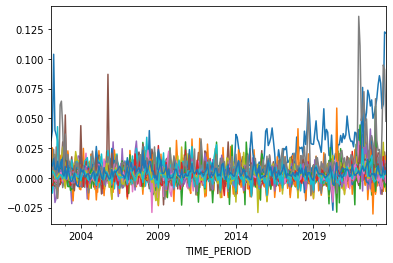

In [447]:
df_infl.plot(legend=False)

In [448]:
train_cutoff = '2013-01-01'
valid_cutoff = '2020-01-01'
df_infl_train, df_infl_valid, df_infl_test = df_infl[:train_cutoff], df_infl[train_cutoff:valid_cutoff], df_infl[valid_cutoff:]
df_infl_train = df_infl_train[:-1]
df_infl_valid = df_infl_valid[:-1]

In [449]:
df_infl_valid

,AR,AT,AU,BE,BG,BR,CA,CH,CL,CN,...,SA,SE,SG,SI,SK,TH,TR,US,XM,ZA
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.011371,-0.004469,0.003922,-0.000302,0.004121,0.0086,0.000825,-0.002611,0.003548,0.010002,...,0.010963,-0.008296,0.001889,-0.008048,0.006035,0.001570,0.016461,0.002957,-0.010392,0.001548
2013-02-01,0.004931,0.002245,0.000000,0.003220,0.000504,0.0060,0.011542,0.002955,0.001187,0.010999,...,0.000863,0.004455,0.010049,0.008114,-0.000245,0.002194,0.002999,0.008190,0.003670,0.010819
2013-03-01,0.007262,0.007839,0.000000,0.001404,-0.005390,0.0047,0.001630,0.002172,0.005572,-0.009005,...,-0.000216,0.004021,-0.005378,0.003018,0.000585,0.000626,0.006624,0.002615,0.011784,0.012233
2013-04-01,0.007275,0.001111,0.003906,-0.000401,-0.004348,0.0055,-0.001627,0.000336,-0.001756,0.002002,...,0.000000,-0.001970,-0.014831,0.007021,0.000362,0.001563,0.004204,-0.001040,-0.000904,0.003021
2013-05-01,0.006900,0.002220,0.000000,0.001503,-0.001421,0.0037,0.002445,0.001100,-0.000532,-0.006002,...,-0.000108,0.001624,0.003553,0.002988,0.001026,0.002497,0.001456,0.001780,0.001105,-0.001506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0.038697,0.001017,0.000000,-0.000184,0.000682,0.0011,-0.001460,-0.000102,0.001855,0.007004,...,0.001940,-0.004199,0.006246,0.003708,0.002069,-0.001894,0.008587,-0.000051,0.001430,0.003304
2019-09-01,0.058082,0.004065,0.000000,-0.004590,-0.003423,-0.0004,-0.004386,-0.001096,0.000097,0.008996,...,0.002343,0.004665,-0.000619,-0.001894,0.001304,0.000899,0.009933,0.000783,0.002189,0.002195
2019-10-01,0.031973,0.003036,0.006932,0.003596,0.008009,0.0010,0.002937,-0.002249,0.008185,0.009000,...,0.000508,0.000268,-0.002167,0.000664,-0.000954,-0.001496,0.020022,0.002286,0.001425,0.000000


### Data preparation

This crucial step involves:
* measuring the mean and standard deviation of the inflation of each country in the training dataset
* using the values above to standardise the training, validation and testing datasets

In [450]:
train_scale = {
    'mean': df_infl_train.mean(axis=0),
    'std': df_infl_train.std(axis=0)
}

In [451]:
def normalise_df(df, scale=train_scale):
    norm_dfs = []
    for cty in df.columns.tolist():
        norm_dfs.append((df[cty] - scale['mean'][cty]) / scale['std'][cty])
    return pd.concat(norm_dfs, axis=1)

In [452]:
def renormalise_df(df, scale=train_scale):
    renorm_dfs = []
    for cty in df.columns.tolist():
        renorm_dfs.append((df[cty] * scale['std'][cty]) + scale['mean'][cty])
    return pd.concat(renorm_dfs, axis=1)

In [453]:
# the code below check that it is working:
# (renormalise_df(normalise_df(df_infl_train, train_scale)) - df_infl_train)

In [454]:
df_infl_train_n = normalise_df(df_infl_train)
df_infl_valid_n = normalise_df(df_infl_valid)
df_infl_test_n = normalise_df(df_infl_test)

<AxesSubplot:xlabel='TIME_PERIOD'>

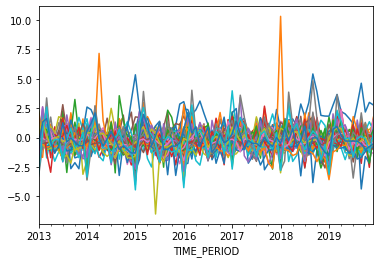

In [455]:
df_infl_valid_n.plot(legend=False)

## A simple dense layer

This first model is autoregressive: it takes in $p$ lags of an inflation series $\pi_i$ (in other words, $\pi_{i, t-p}, ..., \pi_{i, t-1}$) to predict the period $\pi_{i,t}$.

Note that the model is very simple:
* each country's inflation series is only predicted by its past values
* the fully connected linear layer learns to pick up any meaningful non-linear interactions between lags, but there is no intrinsic meaning in the order of the lags
* this network will always take in as input a $p$-sized vector of lagged data

### Data formatting

Let's create a simple function that will take a data frame and return a (input, output) tuple for the model.

In [490]:
def dense_layer_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a linear_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)][[col[i]]].values.reshape(-1)
        if np.isnan(X).any():
            continue
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

    #return df.iloc[idx:(idx+p)][[col]].values.reshape(-1), df.iloc[idx+p+1][[col]].values

In [491]:
dense_layer_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)

(array([[0.00209779, 0.00419757, 0.01190234, 0.00649815],
        [0.00419757, 0.01190234, 0.00649815, 0.00719811],
        [0.01190234, 0.00649815, 0.00719811, 0.01310222]]),
 array([[0.00719811],
        [0.01310222],
        [0.03020224]]))

In [492]:
def random_select(df, p, n_samples):
    max_index = len(df) - p
    rand_idx, rand_col = [], []
    for _ in range(n_samples):
        rand_idx.append(random.randint(0, max_index-2)) # instead of -1 only, we also need to account for the target value
        rand_col.append(random.choice(df.columns))
    return rand_idx, rand_col

In [493]:
n_samples = 1000 # with replacement

In [494]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = dense_layer_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = dense_layer_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

### Model

In [503]:
#nn_linear = linear_layer(size=p)

nn_linear = keras.Sequential([
    layers.Input((p,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

In [504]:
nn_linear.summary()

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_169 (Dense)               │ (None, 32)                │        800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_170 (Dense)               │ (None, 5)                 │        165 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_171 (Dense)               │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 971 (3.79 KB)

 Trainable params: 971 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [505]:
nn_linear.layers[0].get_weights()

[array([[-1.25436381e-01,  1.37049228e-01,  1.69924617e-01,
          1.69283301e-01,  3.71685624e-02,  1.57691419e-01,
         -2.91454375e-01,  8.29318464e-02,  2.17539907e-01,
         -2.31632426e-01,  2.12575018e-01,  2.59149551e-01,
          2.81261146e-01,  2.26867795e-01,  1.89939857e-01,
          8.64438415e-02, -1.20107204e-01, -2.42888093e-01,
         -1.28105298e-01, -2.05363899e-01,  9.20752585e-02,
          2.23235607e-01,  1.40925765e-01, -5.99078536e-02,
         -2.08548039e-01, -1.64981365e-01,  2.42001295e-01,
         -2.01440781e-01,  2.55879223e-01,  2.39253163e-01,
          2.37589896e-01,  1.82021558e-01],
        [ 6.54733479e-02,  1.08548582e-01,  2.45202303e-01,
          2.79301167e-01, -1.99180484e-01,  1.05306387e-01,
         -3.04478765e-01,  9.50431526e-02,  3.09630513e-01,
         -1.88650832e-01,  1.38486296e-01, -2.06741154e-01,
          1.00098401e-01,  1.02334589e-01, -2.41440281e-01,
          3.08910370e-01, -1.00503206e-01,  2.84006715e-

In [506]:
nn_linear.layers[1].get_weights()

[array([[ 0.39539236,  0.29364318, -0.0604305 ,  0.11099201,  0.19382256],
        [-0.03695315, -0.25778502, -0.06532678, -0.1760405 , -0.10289699],
        [-0.03100872, -0.08885595,  0.25190878,  0.12284791, -0.28754428],
        [ 0.22087902, -0.09892133,  0.01420406, -0.3273177 ,  0.04801318],
        [ 0.15591824,  0.01036385,  0.03119728,  0.01280636, -0.27067405],
        [-0.06940421,  0.03067383,  0.22537178, -0.2658053 ,  0.17310858],
        [ 0.16001713, -0.3015855 , -0.19281846,  0.13813543, -0.10343617],
        [ 0.13829786, -0.01574022, -0.00988516, -0.3462799 ,  0.16332376],
        [-0.03111202,  0.00705218,  0.01551238,  0.29308164,  0.2955314 ],
        [-0.12915573,  0.18651861,  0.39866912, -0.35268575, -0.35925484],
        [-0.25027543, -0.2037459 , -0.3059114 , -0.07918778,  0.3984518 ],
        [ 0.22206116, -0.31220734, -0.39567378, -0.28975758, -0.11959776],
        [-0.28152186, -0.24652521, -0.11150283,  0.33754236, -0.00961536],
        [-0.16788217, -0.

In [507]:
nn_linear.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [508]:
assert nn_linear(train_samples[0]).shape == train_samples[1].shape

In [509]:
history_dense = nn_linear.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0624 - rmse: 1.0291 - val_loss: 0.9658 - val_rmse: 0.9828
Epoch 2/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8046 - rmse: 0.8964 - val_loss: 0.8588 - val_rmse: 0.9267
Epoch 3/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7532 - rmse: 0.8677 - val_loss: 0.8101 - val_rmse: 0.9000
Epoch 4/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - rmse: 0.8182 - val_loss: 0.7645 - val_rmse: 0.8744
Epoch 5/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6040 - rmse: 0.7752 - val_loss: 0.7337 - val_rmse: 0.8566
Epoch 6/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5271 - rmse: 0.7236 - val_loss: 0.7318 - val_rmse: 0.8555
Epoch 7/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5775 - rmse: 0.7595 - val_loss: 0.7214 - val_rmse: 0.8494
Epoch 8/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5454 - rmse: 0.7372 - val_loss: 0.7223 - val_rmse: 0.8499
Epoch 9/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

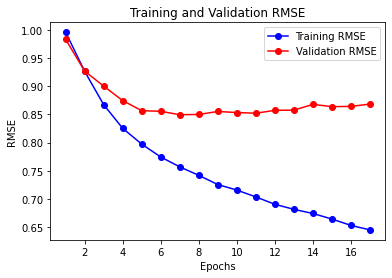

In [510]:
train_loss = history_dense.history['rmse']
val_loss = history_dense.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM neural network

In [535]:
def lstm_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a linear_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

In [536]:
lstm = layers.LSTM(units=64, return_sequences=True, return_state=False)
fl = layers.Flatten()

In [534]:
train_samples[0][:5].shape

(5, 24)

In [531]:
nn_lstm = keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
    #layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(15, activation='relu'),
    layers.Dense(1)
])

In [525]:
assert nn_lstm(np.expand_dims(train_samples[0], axis=-1)).shape == train_samples[1].shape

In [526]:
nn_lstm.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                  │ (988, 24, 64)             │     16,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_22 (Flatten)            │ (988, 1536)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_174 (Dense)               │ (988, 15)                 │     23,055 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_175 (Dense)               │ (988, 1)                  │         16 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 39,967 (156.12 KB)

 Trainable params: 39,967 (156.12 KB)

 Non-trainable params: 0 (0.00 B)

In [527]:
nn_lstm.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [528]:
history_lstm = nn_lstm.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500


2023-12-13 04:11:46.375325: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1


InvalidArgumentError: Graph execution error:

Detected at node sequential_65_1/flatten_22_1/Reshape defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 595, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 424, in do_execute

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code

  File "/var/folders/b9/p8z57lqd55xfk68xz34dg0s40000gn/T/ipykernel_3761/3066928478.py", line 1, in <module>

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py", line 831, in __call__

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/models/sequential.py", line 203, in call

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/models/functional.py", line 188, in call

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/models/functional.py", line 572, in call

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py", line 831, in __call__

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 4501, in reshape

  File "/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1279, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_65_1/flatten_22_1/Reshape}}]] [Op:__inference_one_step_on_iterator_1542446]

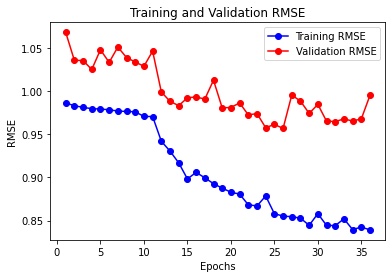

In [518]:
train_loss = history_lstm.history['rmse']
val_loss = history_lstm.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM with other countries' inflation data

The difference between this and the previous one is that it is not only autoregressive, but also considers past data from other countries.

### Data formatting

In [421]:
def lstm_cty_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a linear_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.stack(batch_X, axis=0), np.vstack(batch_y)  #np.vstack(batch_X), np.vstack(batch_y)

In [422]:
lstm_cty_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)[0].shape

(3, 4, 61)

In [423]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = lstm_cty_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = lstm__ctyio(df=df_infl_valid_n, idx=idx, col=col, p=p)

In [424]:
train_samples[0].shape

(1000, 24, 61)

### Model

In [439]:
nn_lstm_cty = keras.Sequential([
    layers.LSTM(units=30, return_sequences=True, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(15, activation='relu'),
    layers.Dense(1)
])

In [440]:
nn_lstm_cty.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_20 (Flatten)            │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_143 (Dense)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_144 (Dense)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [441]:
assert nn_lstm_cty(train_samples[0]).shape == train_samples[1].shape

In [442]:
nn_lstm_cty.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [443]:
train_samples[0].shape

(1000, 24, 61)

In [444]:
history_lstm_cty = nn_lstm_cty.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7813 - rmse: 0.8829 - val_loss: 2.5626 - val_rmse: 1.6008
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6313 - rmse: 0.7935 - val_loss: 2.6443 - val_rmse: 1.6261
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6424 - rmse: 0.8000 - val_loss: 2.5030 - val_rmse: 1.5821
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6886 - rmse: 0.8293 - val_loss: 2.4627 - val_rmse: 1.5693
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6486 - rmse: 0.8043 - val_loss: 2.3683 - val_rmse: 1.5389
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6308 - rmse: 0.7935 - val_loss: 2.3862 - val_rmse: 1.5447
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6635 - rmse: 0.8129 - val_loss: 2.6140 - val_rmse: 1.6168
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6976 - rmse: 0.8346 - val_loss: 2.4875 - val_rmse: 1.5772
Epoch 9/500
100/100 ━━━━━━━━━━━━

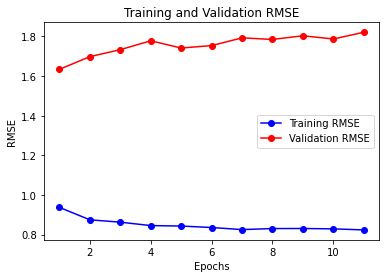

In [438]:
train_loss = history_lstm_cty.history['rmse']
val_loss = history_lstm_cty.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## Model with date features

Repeating date features (eg, day in the week, month, quarter and year, week in the month, quarter and year, month in the quarter and year, and quarter in year) can be embedded and included in the model.

In [ ]:
#nn_lstm_datefeat = layers.LSTM()

## Creating a TFT model

In [ ]:
tft = TemporalFusionTransformer(
    time_steps=12,
    input_size=20,
    output_size=4,
    category_counts=5,
    n_workers=2, # Number of multiprocessing workers

    # TFT params
    input_obs_loc=24,
    static_input_loc=24,
    known_regular_input_idx=24,
    known_categorical_input_idx=24,
    column_definition=None,
)

In [ ]:
tft.time_steps

# Test

In [ ]:
batch_size = 3
n_timesteps = 4

univariate_x = np.ones(shape=(batch_size, n_timesteps))
univariate_x = keras.ops.expand_dims(univariate_x, axis=-1)
univariate_x.shape

TensorShape([3, 4, 1])

In [ ]:
lstm = layers.LSTM(
    units=6,
    return_sequences=True,
    return_state=False,
)

In [ ]:
transf_x = lstm(univariate_x)
transf_x.shape, keras.ops.concatenate([transf_x, transf_x], axis=1).shape

(TensorShape([3, 4, 6]), TensorShape([3, 8, 6]))

In [ ]:
transf_x.shape

TensorShape([3, 14])

# References {.unnumbered}